# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [89]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [90]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

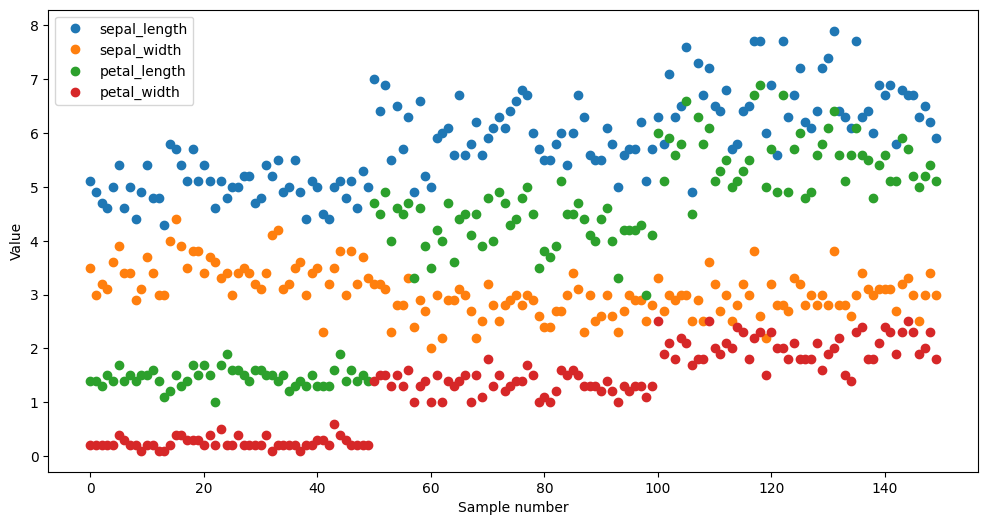

In [91]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [92]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [93]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [94]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 1

# train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
# test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??
for i in range(6):
    print(f'Batchsize is {batchsize}')
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??
    batchsize += 1

Batchsize is 1
Batchsize is 2
Batchsize is 3
Batchsize is 4
Batchsize is 5
Batchsize is 6


In [95]:
len(train_data)

120

In [96]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])
torch.Size([6, 4]) torch.Size([6])


# Construct the model and training plans

In [97]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.001)

  return ANNiris,lossfun,optimizer

In [112]:
# train the model

# global parameter
numepochs = 100

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):
    print(f'Epochi is {epochi}')

    # loop over training data batches
    batchsize = 2
    for i in range(6):
      batchAcc  = []
      batchLoss = []
      print(f'Batchsize is {batchsize}')
      
      train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
      test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??
      batchsize = batchsize ** i


      for X,y in train_loader:

        # forward pass and loss
        yHat = ANNiris(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute training accuracy just for this batch
        batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batchLoss.append( loss.item() )
      # end of batch loop...

      # now that we've trained through the batches, get their average training accuracy
      trainAcc.append( [i, np.mean(batchAcc)] )
      losses.append( [i, np.mean(batchLoss)] )

      # test accuracy
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      with torch.no_grad():
        predlabels = torch.argmax( ANNiris(X),axis=1 )
      testAcc.append( [i, 100*torch.mean((predlabels == y).float()).item()] )

    # function output
  return trainAcc,testAcc,losses


# Test it out

In [99]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()


Epochi is 0
Batchsize is 2
Batchsize is 1


Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 1
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 2
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 3
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 4
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 5
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 6
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 7
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 8
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 9
Batchsize is 2
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Batchsize is 1
Epochi is 10
Batchsize

In [105]:
trainAcc

[[0, 35.0],
 [1, 35.0],
 [2, 41.666666666666664],
 [3, 66.66666666666667],
 [4, 67.5],
 [5, 67.5],
 [0, 67.5],
 [1, 68.33333333333333],
 [2, 67.5],
 [3, 71.66666666666667],
 [4, 69.16666666666667],
 [5, 77.5],
 [0, 70.83333333333333],
 [1, 77.5],
 [2, 77.5],
 [3, 80.83333333333333],
 [4, 85.0],
 [5, 92.5],
 [0, 76.66666666666667],
 [1, 86.66666666666667],
 [2, 84.16666666666667],
 [3, 90.83333333333333],
 [4, 90.0],
 [5, 95.0],
 [0, 95.0],
 [1, 91.66666666666667],
 [2, 94.16666666666667],
 [3, 93.33333333333333],
 [4, 92.5],
 [5, 94.16666666666667],
 [0, 94.16666666666667],
 [1, 95.83333333333333],
 [2, 94.16666666666667],
 [3, 92.5],
 [4, 96.66666666666667],
 [5, 94.16666666666667],
 [0, 96.66666666666667],
 [1, 95.0],
 [2, 94.16666666666667],
 [3, 95.83333333333333],
 [4, 94.16666666666667],
 [5, 96.66666666666667],
 [0, 95.83333333333333],
 [1, 93.33333333333333],
 [2, 96.66666666666667],
 [3, 95.83333333333333],
 [4, 95.83333333333333],
 [5, 97.5],
 [0, 96.66666666666667],
 [1, 97.

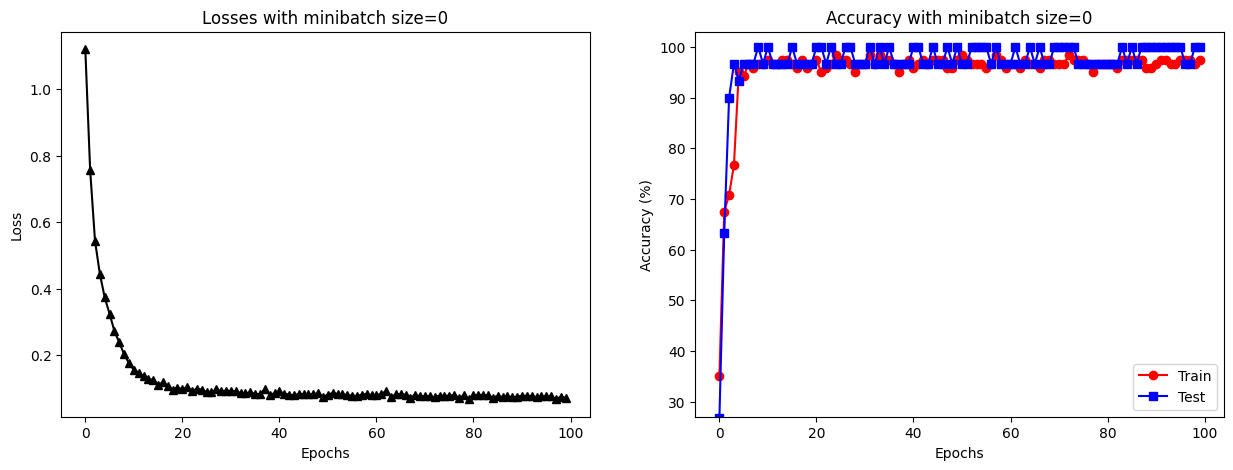

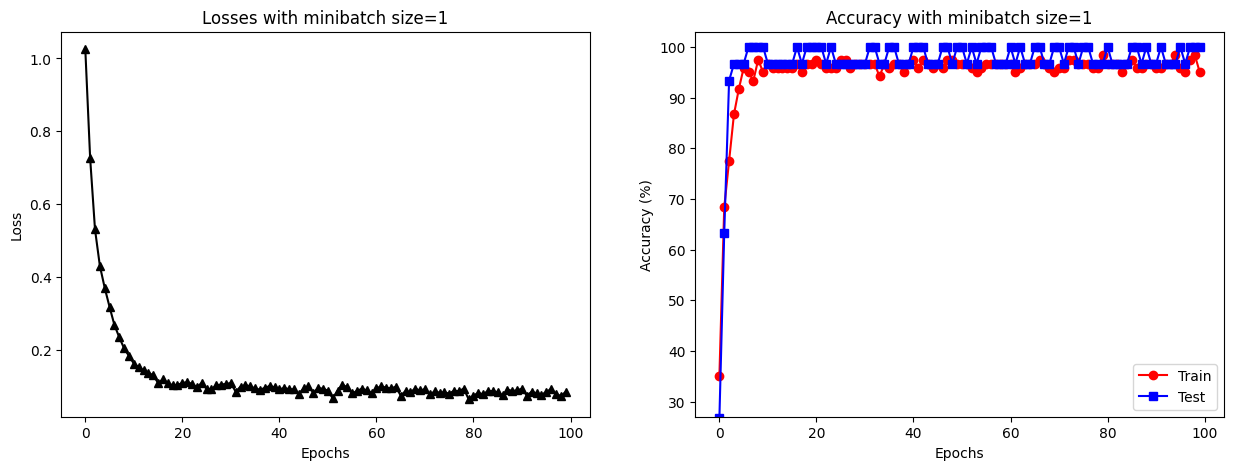

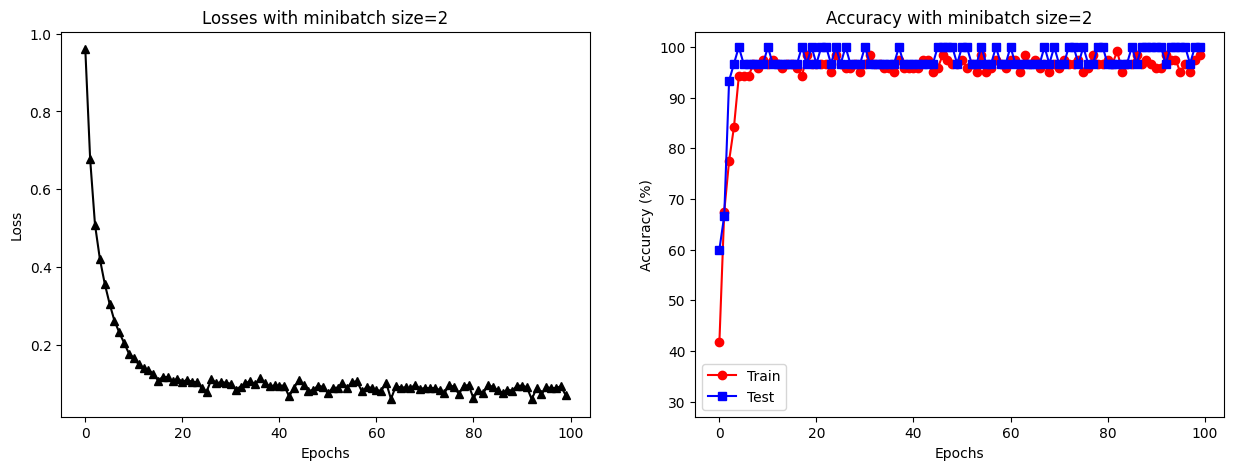

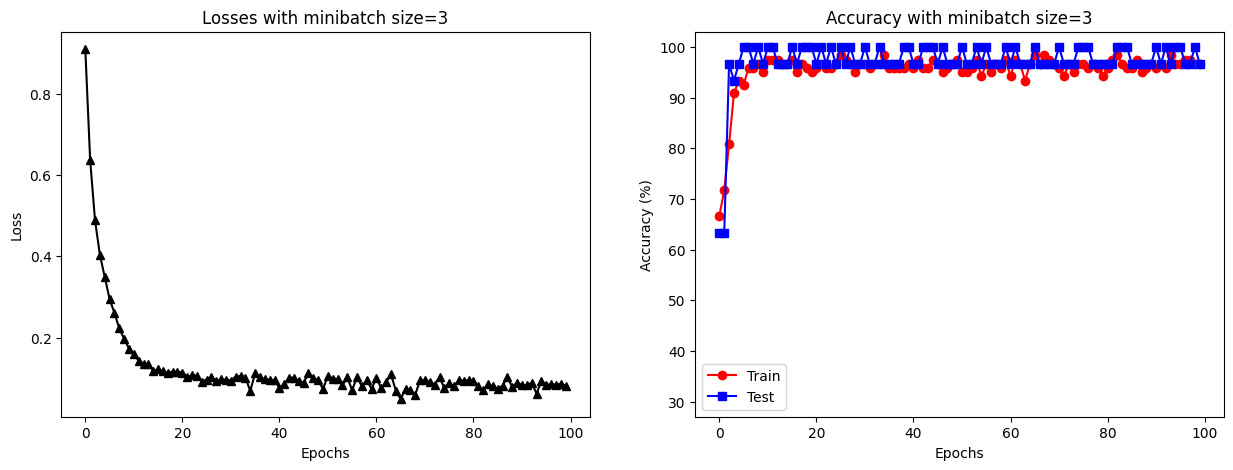

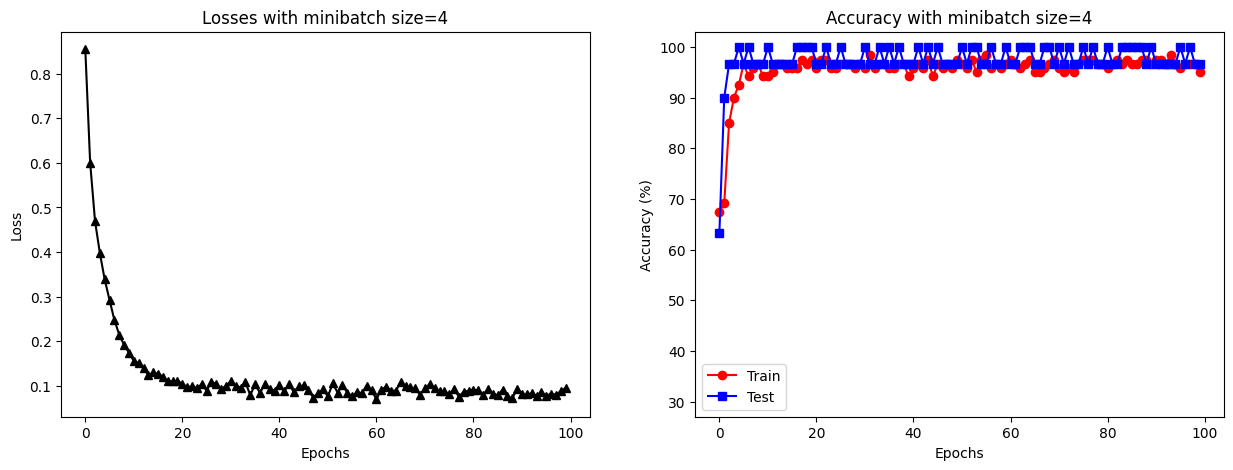

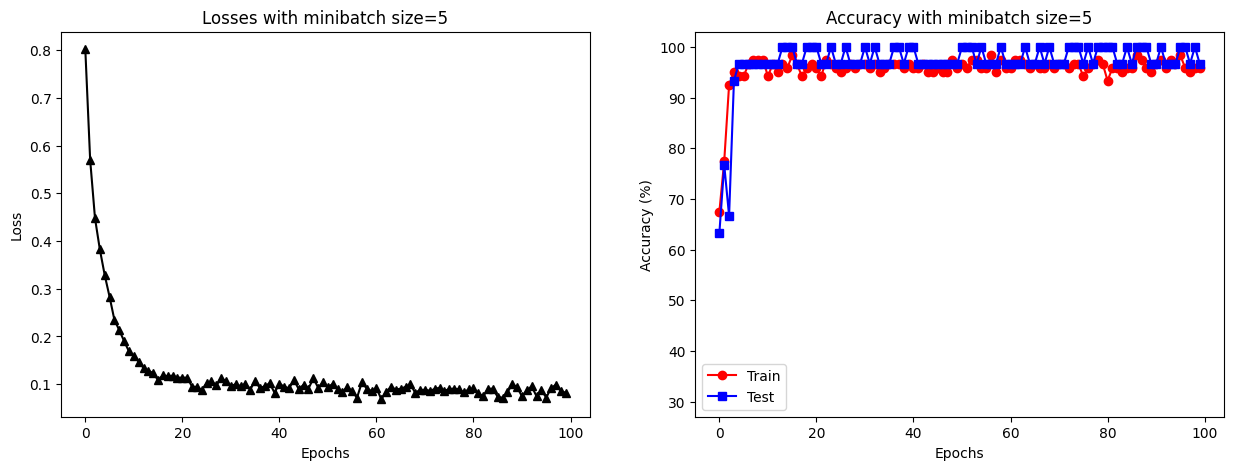

In [111]:
# plot the results


for i in range(6):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    batchlosses = [item[1] for item in losses if item[0] == i]
    batchtrainAcc = [item[1] for item in trainAcc if item[0] == i]
    batchtestAcc = [item[1] for item in testAcc if item[0] == i]
    ax[0].plot(batchlosses,'k^-')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Losses with minibatch size=' + str(i))

    ax[1].plot(batchtrainAcc,'ro-')
    ax[1].plot(batchtestAcc,'bs-')
    ax[1].set_title('Accuracy with minibatch size=' + str(i))
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].legend(['Train','Test'])
    ax[1].set_ylim([27,103])

plt.show()

# Additional explorations

In [102]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
#
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or
#    "other." What would you have to change in the data and in the model to make this work?
#
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
#